In [14]:
import pandas as pd
import numpy as np
df = pd.read_csv('S&P500.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-30,2251.610107,2253.580078,2233.620117,2238.830078,2238.830078,2671550000
1,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
3,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
4,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
...,...,...,...,...,...,...,...
247,2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2683.340088,2401030000
248,2017-12-26,2679.090088,2682.739990,2677.959961,2680.500000,2680.500000,1970660000
249,2017-12-27,2682.100098,2685.639893,2678.909912,2682.620117,2682.620117,2202900000
250,2017-12-28,2686.100098,2687.659912,2682.689941,2687.540039,2687.540039,2174890000


In [15]:
# Assuming df is your DataFrame
df['Volatility'] = df['Adj Close'].pct_change().rolling(window=2).std() * 100

In [16]:
volatility  = df[['Date','Volatility']]
import datetime
volatility['Date'] = pd.to_datetime(volatility['Date'])
volatility.set_index('Date', inplace = True)

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


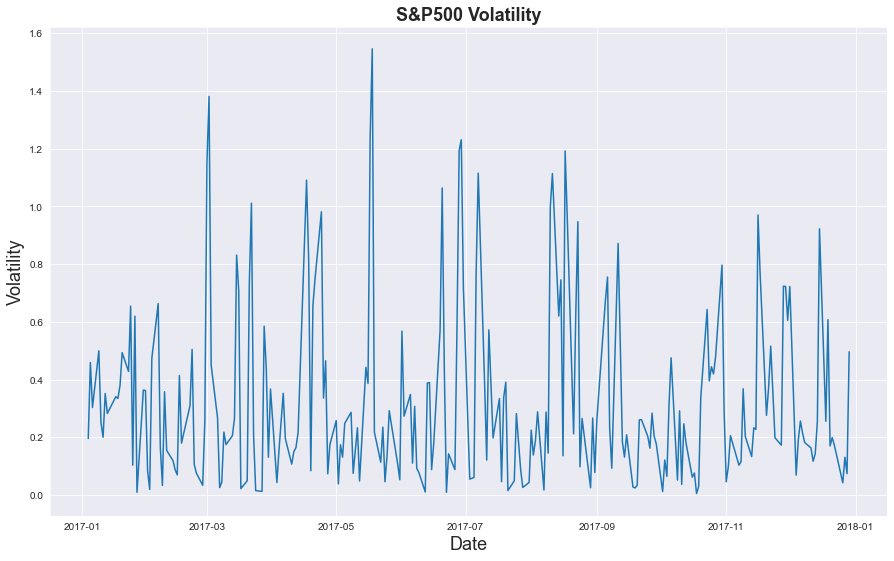

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(volatility['Volatility'])
plt.title("S&P500 Volatility", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volatility', fontsize=18)
plt.show()

In [18]:
price = df[['Volatility']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Volatility  250 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
#price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))
price['Volatility'] = scaler.fit_transform(price['Volatility'].values.reshape(-1,1))

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]
    return x_train, y_train, x_test, y_test

In [21]:
lookback = 20  # Number of previous days to consider
data = split_data(price, lookback)

In [22]:
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (186, 19, 1)
y_train.shape = (186, 1)
x_test.shape = (46, 19, 1)
y_test.shape = (46, 1)


In [23]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [24]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Assuming x_train and y_train are NumPy arrays
x_train = torch.nan_to_num(x_train, nan=0.0)
# Example usage
input_dim = 19
output_dim = 1  # adjust based on your output data
num_epochs = 100

# Reshape x_train to 2D array
x_train_2d = x_train.reshape((x_train.shape[0], -1))
print(x_train_2d)
print('x_train_2d.shape =',x_train_2d.shape)
# Initialize SVR model
model = SVR(kernel='rbf', C=1e3, gamma=0.1)

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Fit the SVR model
    model.fit(x_train_2d, y_train.squeeze())

    # Make predictions
    y_train_pred = model.predict(x_train_2d)
    # Calculate MSE
    loss = mean_squared_error(y_train.squeeze(), y_train_pred)
    
    print(f'Epoch {t + 1}/{num_epochs}, Loss: {loss}')
    hist[t] = loss


tensor([[ 0.0000,  0.0000, -0.7527,  ..., -0.8723, -0.2024, -0.9944],
        [ 0.0000, -0.7527, -0.4106,  ..., -0.2024, -0.9944, -0.5345],
        [-0.7527, -0.4106, -0.6130,  ..., -0.9944, -0.5345, -0.5366],
        ...,
        [-0.6675, -0.7431, -0.7959,  ..., -0.9263, -0.9075, -1.0000],
        [-0.7431, -0.7959, -0.6382,  ..., -0.9075, -1.0000, -0.9684],
        [-0.7959, -0.6382, -0.7421,  ..., -1.0000, -0.9684, -0.5670]])
x_train_2d.shape = torch.Size([186, 19])
Epoch 1/100, Loss: 0.009273969586827975
Epoch 2/100, Loss: 0.009273969586827975
Epoch 3/100, Loss: 0.009273969586827975
Epoch 4/100, Loss: 0.009273969586827975
Epoch 5/100, Loss: 0.009273969586827975
Epoch 6/100, Loss: 0.009273969586827975
Epoch 7/100, Loss: 0.009273969586827975
Epoch 8/100, Loss: 0.009273969586827975
Epoch 9/100, Loss: 0.009273969586827975
Epoch 10/100, Loss: 0.009273969586827975
Epoch 11/100, Loss: 0.009273969586827975
Epoch 12/100, Loss: 0.009273969586827975
Epoch 13/100, Loss: 0.009273969586827975
E

In [25]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.reshape(-1, 1)))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.reshape(-1, 1)))

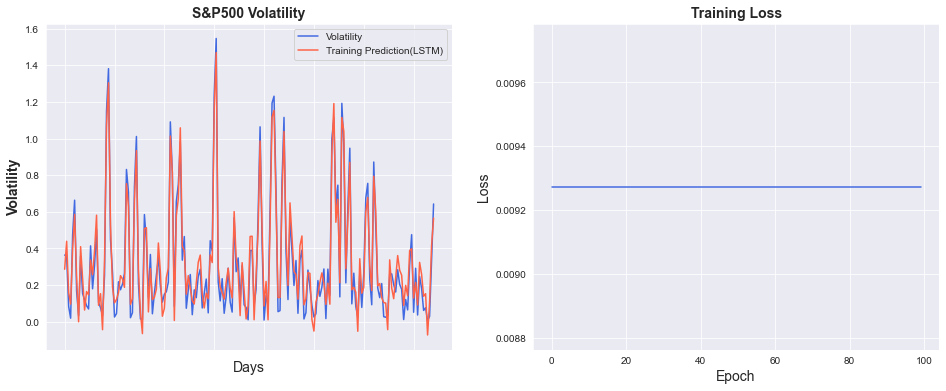

In [26]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x= original.index, y= original[0], label='Volatility', color='royalblue')
ax = sns.lineplot(x= predict.index, y= predict[0], label='Training Prediction(LSTM)', color='tomato')
ax.set_title('S&P500 Volatility', size = 14, fontweight='bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Volatility', size = 14, fontweight='bold')
ax.set_xticklabels('', size = 10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size = 14, fontweight = 'bold')
fig.set_figheight(6)
fig.set_figwidth(16)

不同于神经网络等深度学习模型，支持向量机（Support Vector Machine，SVM）包括支持向量回归（Support Vector Regression，SVR）模型在训练时通常没有迭代次数的概念。SVR 模型的训练是通过解决数学优化问题来实现的，而不是通过迭代训练数据。

SVR 通过寻找支持向量（数据集中的一小部分样本，它们对模型的构建起到关键作用）来构建模型。优化问题的解决通常是直接的数学形式，而不需要像神经网络那样进行多次迭代的梯度下降。

在这种情况下，你在 SVR 模型上训练一次，得到的 MSE 结果就是最终的结果，不需要多次迭代。如果你每次运行 SVR 得到的 MSE 结果相同，那是因为模型的训练是确定性的，对于相同的输入和参数，结果应该是一致的。